In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [1]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

#sys.path.insert(0,'ClassRepository')
from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

ERROR: Cell magic `%%px` not found.


In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']
nu = isotropic1024coarse['nu']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0 #1.024# 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:2] 
n_proc = 8
rank = 0


In [21]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True
store_on_file = False
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/idies/workspace/scratch"
filename = "ref-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vx,vy,vz = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:2] 
Starting the loading process
Finished loading
Load from disk: 76.63 seconds
vx shape = (128, 1024, 1024)


In [5]:
%%px

K = 0.5*(vx**2+vy**2+vz**2)

slabK = np.sum(K)

avgK=np.zeros(1,dtype='float32')

comm.Reduce([slabK,MPI.REAL],[avgK,MPI.REAL],op=MPI.SUM)
avgK = avgK[0]*(1024**(-3))
avgK = comm.bcast(avgK, root=0)

if rank==0:
    print("kinectic energy = "+str(avgK))

[stdout:2] kinectic energy = 0.682719171047


In [6]:
%%px

comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
k2,kx,ky,kz=myEnergySpc.GetWavenumbers(nx,ny,nz,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate all wavenumbers: 33.88 seconds


In [7]:
%%px 
comm.Barrier(); t1=MPI.Wtime()

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Preparing FFT: 54.31 seconds


In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx[:,:,:] = fft.forward3Dfft(vx,nx,ny,nz,nproc,rank)
cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)
cvz[:,:,:] = fft.forward3Dfft(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial FFT: 104.76 seconds


In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cA11 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA12 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA13 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA21 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA22 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA23 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA31 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA32 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA33 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('alocating fourier space derivatives: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] alocating fourier space derivatives: 269.99 seconds


In [10]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cA11[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvx[:,:,:]
cA12[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvy[:,:,:]
cA13[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvz[:,:,:]

cA21[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvx[:,:,:]
cA22[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvy[:,:,:]
cA23[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvz[:,:,:]

cA31[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvx[:,:,:]
cA32[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvy[:,:,:]
cA33[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvz[:,:,:]

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate velocity gradient: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate velocity gradient: 320.76 seconds


In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()

A11 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A12 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A13 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A21 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A22 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A23 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A31 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A32 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A33 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocate real space gradients: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Alocate real space gradients: 114.17 seconds


In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()

A11[:,:,:] = fft.backward3Dfft(cA11,nx,ny,nz,nproc,rank)
A12[:,:,:] = fft.backward3Dfft(cA12,nx,ny,nz,nproc,rank)
A13[:,:,:] = fft.backward3Dfft(cA13,nx,ny,nz,nproc,rank)
A21[:,:,:] = fft.backward3Dfft(cA21,nx,ny,nz,nproc,rank)
A22[:,:,:] = fft.backward3Dfft(cA22,nx,ny,nz,nproc,rank)
A23[:,:,:] = fft.backward3Dfft(cA23,nx,ny,nz,nproc,rank)
A31[:,:,:] = fft.backward3Dfft(cA31,nx,ny,nz,nproc,rank)
A32[:,:,:] = fft.backward3Dfft(cA32,nx,ny,nz,nproc,rank)
A33[:,:,:] = fft.backward3Dfft(cA33,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate inverse 3D spatial FFT - velocity gradients: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate inverse 3D spatial FFT - velocity gradients: 302.61 seconds


In [13]:
%%px


del vx
del vy
del vz

In [14]:
%%px 

del cvx,cvy,cvz
del cA11,cA12,cA13
del cA21,cA22,cA23
del cA31,cA32,cA33

In [15]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    Aav = np.average(A[i])
    slabAavg = np.sum(Aav)
    
    avgA =np.zeros(1,dtype='float32')
    
    comm.Reduce([slabAavg,MPI.REAL],[avgA,MPI.REAL],op=MPI.SUM)
    avgA = avgA[0]/nproc #avgK[0]*(1024**(-3))
    avgA = comm.bcast(avgA, root=0)
    
    if rank==0:
        print("<"+la[i]+"> = "+str(avgA))

[stdout:2] 
<A11> = -1.01607611214e-11
<A12> = -1.9371509552e-07
<A13> = 5.21540641785e-07
<A21> = -4.51336745755e-11
<A22> = -1.10162545752e-10
<A23> = -6.59895249555e-10
<A31> = 7.5606187977e-13
<A32> = 3.22852855561e-11
<A33> = 1.04782849064e-12


In [16]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    A2av = np.average(A[i]**2)
    
    avgA2 =np.zeros(1,dtype='float32')
    
    comm.Reduce([A2av,MPI.REAL],[avgA2,MPI.REAL],op=MPI.SUM)
    avgA2 = avgA2[0]/nproc #avgK[0]*(1024**(-3))
    avgA2 = comm.bcast(avgA2, root=0)
    
    if rank==0:
        print("<"+la[i]+"^2> = "+str(avgA2))

[stdout:2] 
<A11^2> = 33.2611160278
<A12^2> = 66.9627380371
<A13^2> = 67.0288848877
<A21^2> = 65.7715530396
<A22^2> = 33.0682907104
<A23^2> = 65.7397689819
<A31^2> = 66.6280975342
<A32^2> = 66.7571411133
<A33^2> = 33.2177276611


In [17]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):  
    A2av = np.average(A[i]**2)
    A3av = np.average(A[i]**3)
    
    avgA2 =np.zeros(1,dtype='float32')
    avgA3 =np.zeros(1,dtype='float32')
    
    comm.Reduce([A2av,MPI.REAL],[avgA2,MPI.REAL],op=MPI.SUM)
    comm.Reduce([A3av,MPI.REAL],[avgA3,MPI.REAL],op=MPI.SUM)
    
    avgA2 = avgA2[0]/nproc 
    avgA2 = comm.bcast(avgA2, root=0)
    avgA3 = avgA3[0]/nproc 
    avgA3 = comm.bcast(avgA3, root=0)
    
    if rank==0:
        print("skewness = <"+la[i]+"^3>/"+"<"+la[i]+"^2>^(3/2) "+"= "+str(avgA3/(avgA2**(3/2))) )

[stdout:2] 
skewness = <A11^3>/<A11^2>^(3/2) = -0.590255673714
skewness = <A12^3>/<A12^2>^(3/2) = -0.0262069046671
skewness = <A13^3>/<A13^2>^(3/2) = -0.0446001044037
skewness = <A21^3>/<A21^2>^(3/2) = -0.00580454587372
skewness = <A22^3>/<A22^2>^(3/2) = -0.553908776151
skewness = <A23^3>/<A23^2>^(3/2) = -0.0494112993707
skewness = <A31^3>/<A31^2>^(3/2) = 0.00386568212556
skewness = <A32^3>/<A32^2>^(3/2) = 0.00726923617989
skewness = <A33^3>/<A33^2>^(3/2) = -0.576320650439


In [18]:
%%px 

div = A11+A22+A33 

div2av = np.average(div**2)
    
avgdiv2 =np.zeros(1,dtype='float32')
   
comm.Reduce([div2av,MPI.REAL],[avgdiv2,MPI.REAL],op=MPI.SUM)
avgdiv2 = avgdiv2[0]/nproc 
avgdiv2 = comm.bcast(avgdiv2, root=0)

if rank==0:
    print("<(div v)^2> = "+str(avgdiv2))

[stdout:2] <(div v)^2> = 5.53647616641e-09


In [22]:
%%px

vx_xlp = vx[:,0,0]

vx_xl = comm.gather(vx_xlp,root=0)
if rank==0:
    l = tuple(vx_xl)
    vx_xl = np.concatenate(l)

vx_yl = vx[0,:,0]
vx_zl = vx[0,0,:]

##########################

vy_xlp = vy[:,0,0]

vy_xl = comm.gather(vy_xlp,root=0)
if rank==0:
    l = tuple(vy_xl)
    vy_xl = np.concatenate(l)

vy_yl = vy[0,:,0]
vy_zl = vy[0,0,:]

##########################

vz_xlp = vz[:,0,0]

vz_xl = comm.gather(vz_xlp,root=0)
if rank==0:
    l = tuple(vz_xl)
    vz_xl = np.concatenate(l)

vz_yl = vz[0,:,0]
vz_zl = vz[0,0,:]

if rank==0:
    print(vx_xl.shape)
    print(vx_yl.shape)
    print(vx_zl.shape)

[stdout:2] 
(1024,)
(1024,)
(1024,)


In [23]:
%%px

vx_xlpdx = A11[:,0,0]

vx_xldx = comm.gather(vx_xlpdx,root=0)
if rank==0:
    ldx = tuple(vx_xldx)
    vx_xldx = np.concatenate(ldx)

vx_yldx = A21[0,:,0]
vx_zldx = A31[0,0,:]

########################

vy_xlpdx = A12[:,0,0]

vy_xldx = comm.gather(vy_xlpdx,root=0)
if rank==0:
    ldy = tuple(vy_xldx)
    vy_xldx = np.concatenate(ldy)

vy_yldx = A22[0,:,0]
vy_zldx = A32[0,0,:]

########################


vz_xlpdx = A13[:,0,0]

vz_xldx = comm.gather(vz_xlpdx,root=0)
if rank==0:
    ldz = tuple(vz_xldx)
    vz_xldx = np.concatenate(ldz)

vz_yldx = A23[0,:,0]
vz_zldx = A33[0,0,:]

[stdout:0] (1024,)
[stdout:1] (1024,)
[stdout:2] (1024,)
[stdout:3] (1024,)
[stdout:4] (1024,)
[stdout:5] (1024,)
[stdout:6] (1024,)
[stdout:7] (1024,)


[output:2]

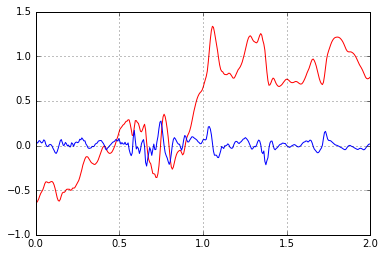

In [24]:
%%px
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

Y = np.linspace(0,2.*np.pi,Ny)
print(Y.shape)

if rank==0:
    plt.plot(Y,vx_xl,'r-')
    plt.plot(Y,vx_xldx/100,'b-')
    plt.grid()
    
    plt.xlim((0,2))
    
    plt.show()

[output:2]

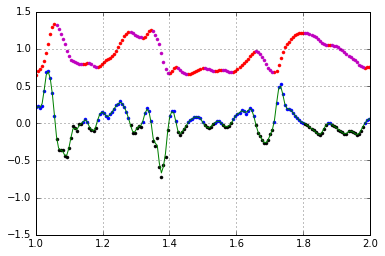

In [25]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vlgrx = np.gradient(vx_xl)/dx
    
    plt.plot(Y[pos],vx_xl[pos],'r.')
    plt.plot(Y[pos],vx_xldx[pos]/scale,'b.')
    
    plt.plot(Y[neg],vx_xl[neg],'m.')
    plt.plot(Y[neg],vx_xldx[neg]/scale,'k.')
    
    plt.plot(Y,vlgrx/scale,'g')
    plt.grid()
    
    plt.xlim((1,2))
    
    plt.show()

[output:2]

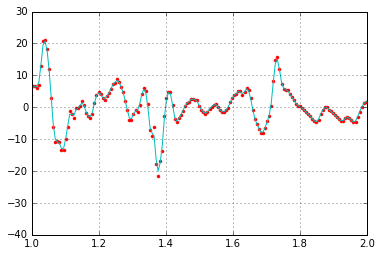

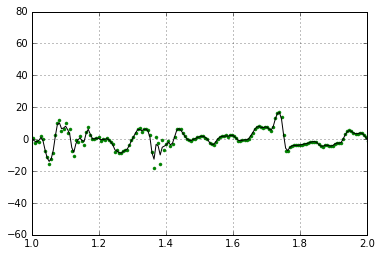

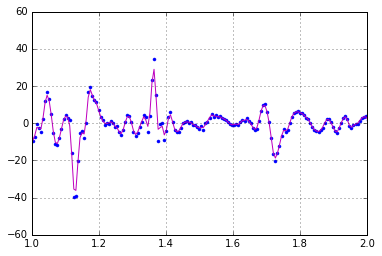

In [26]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vxlgrx = np.gradient(vx_xl)/dx
    vylgrx = np.gradient(vy_xl)/dx
    vzlgrx = np.gradient(vz_xl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_xldx,'r.')
    plt.plot(Y,vxlgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_xldx,'g.')
    plt.plot(Y,vylgrx,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vz_xldx,'b.')
    plt.plot(Y,vzlgrx,'m-')
    
    plt.show()
    

[output:2]

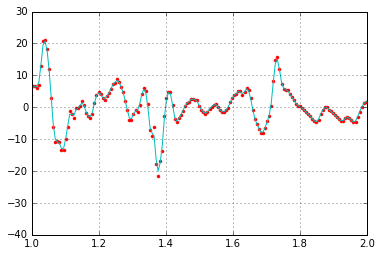

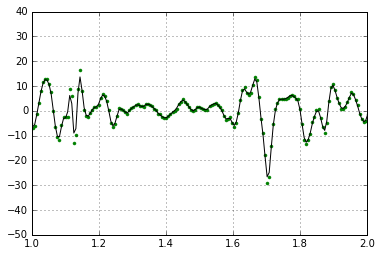

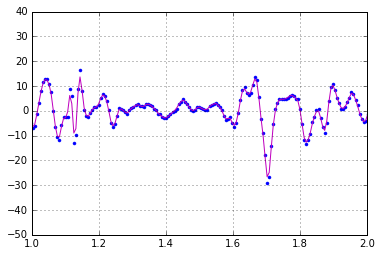

In [27]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vxlgrx = np.gradient(vx_xl)/dx
    vxlgry = np.gradient(vx_yl)/dx
    vxlgrz = np.gradient(vx_zl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_xldx,'r.')
    plt.plot(Y,vxlgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_yldx,'g.')
    plt.plot(Y,vxlgry,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vx_yldx,'b.')
    plt.plot(Y,vxlgry,'m-')
    
    plt.show()
    

[output:2]

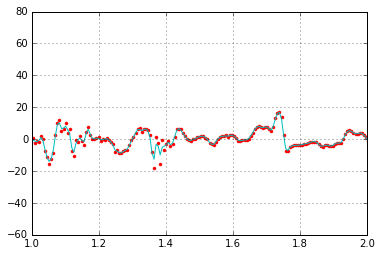

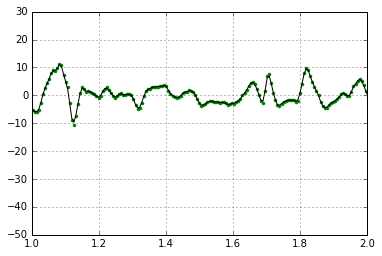

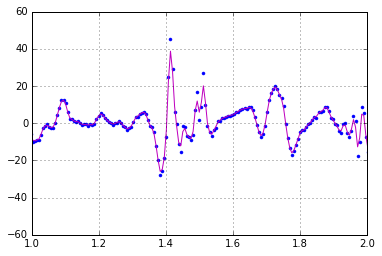

In [28]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    scale = 30
    
    dx = 2.*np.pi/1024
    vylgrx = np.gradient(vy_xl)/dx
    vylgry = np.gradient(vy_yl)/dx
    vylgrz = np.gradient(vy_zl)/dx
            
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_xldx,'r.')
    plt.plot(Y,vylgrx,'c-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_yldx,'g.')
    plt.plot(Y,vylgry,'k-')
    
    plt.show()
    
    plt.xlim((1,2))
    plt.grid()
    plt.plot(Y,vy_zldx,'b.')
    plt.plot(Y,vylgrz,'m-')
    
    plt.show()

Now prepare the gradient tensor invariants averages, which should all be zero.

In [29]:
%%px 

Q = 0.5*( (A12*A21+A23*A32+A13*A31) - (A22*A33+A11*A33+A11*A22) )

In [34]:
%%px

slabQ = np.average(Q)

avgQ=np.zeros(1,dtype='float32')

comm.Reduce([slabQ,MPI.REAL],[avgQ,MPI.REAL],op=MPI.SUM)
avgQ = avgQ[0]/nproc
avgQ = comm.bcast(avgQ, root=0)

if rank==0:
    print("Average Q = "+str(avgQ))

[stdout:2] Average Q = 1.1408701539e-07


In [31]:
%%px

R = A11**3 + A22**3 + A33**3 + 3*( A11*(A21*A12+A13*A31) + A22*(A12*A21+A23*A32) + A33*(A13*A31+A23*A32) + A13*A21*A32 + A12*A23*A31 )

In [33]:
%%px

slabR = np.average(R)

avgR=np.zeros(1,dtype='float32')

comm.Reduce([slabR,MPI.REAL],[avgR,MPI.REAL],op=MPI.SUM)
avgR = avgR[0]/nproc
avgR = comm.bcast(avgR, root=0)

if rank==0:
    print("Average R = "+str(avgR))

[stdout:2] Average R = -0.00386608392


In [35]:
%%px

slabQ2 = np.average(Q**2)

avgQ2=np.zeros(1,dtype='float32')

comm.Reduce([slabQ2,MPI.REAL],[avgQ2,MPI.REAL],op=MPI.SUM)
avgQ2 = avgQ2[0]/nproc
avgQ2 = comm.bcast(avgQ2, root=0)

if rank==0:
    print("Average Q^2 = "+str(avgQ2))

[stdout:2] Average Q^2 = 17679.1640625


In [37]:
%%px

slabR = np.average(R)

avgR=np.zeros(1,dtype='float32')

comm.Reduce([slabR,MPI.REAL],[avgR,MPI.REAL],op=MPI.SUM)
avgR = avgR[0]/nproc
avgR = comm.bcast(avgR, root=0)

if rank==0:
    print("<R>/(<Q^2>^3/2) = "+str(avgR/(avgQ2**1.5)))

[stdout:2] <R>/(<Q^2>^3/2) = -1.6446696862e-09


In [38]:
%%px 

del Q,R

In [40]:
%%px

Omega = 2.*(((A12-A21)/2.)**2 + ((A13-A13)/2.)**2 + ((A23-A32)/2.)**2 )

In [41]:
%%px

Epsilon = A11**2 + A22**2 + A33**2 + 2.*( ((A12+A21)/2.)**2 + ((A13+A13)/2.)**2 + ((A23+A32)/2.)**2 )

In [42]:
%%px

slabO = np.average(Omega)

avgO=np.zeros(1,dtype='float32')

comm.Reduce([slabO,MPI.REAL],[avgO,MPI.REAL],op=MPI.SUM)
avgO = avgO[0]/nproc
avgO = comm.bcast(avgO, root=0)

if rank==0:
    print("Average enstrophy = "+str(avgO))

[stdout:2] Average enstrophy = 165.684020996


In [43]:
%%px

slabE = np.average(Epsilon)

avgE=np.zeros(1,dtype='float32')

comm.Reduce([slabE,MPI.REAL],[avgE,MPI.REAL],op=MPI.SUM)
avgE = avgE[0]/nproc
avgE = comm.bcast(avgE, root=0)

if rank==0:
    print("Average strainrate = "+str(avgE))

[stdout:2] Average strainrate = 333.151733398


In [45]:
%%px

Omega = 0.5*( A12**2 + A21**2 + A13**2 + A31**2 + A23**2 + A32**2 - 2.*(A12*A21+A13*A31+A23*A32) )

In [46]:
%%px

slabO = np.average(Omega)

avgO=np.zeros(1,dtype='float32')

comm.Reduce([slabO,MPI.REAL],[avgO,MPI.REAL],op=MPI.SUM)
avgO = avgO[0]/nproc
avgO = comm.bcast(avgO, root=0)

if rank==0:
    print("Average enstrophy = "+str(avgO))

[stdout:2] Average enstrophy = 249.217727661


In [48]:
%%px

Epsilon  = A11**2 + A22**2 + A33**2 
Epsilon += 0.5*( A12**2 + A21**2 + A23**2 + A32**2 + A13**2 + A31**2 )
Epsilon += A12*A21 + A13*A31 + A23*A32

In [49]:
%%px

slabE = np.average(Epsilon)

avgE=np.zeros(1,dtype='float32')

comm.Reduce([slabE,MPI.REAL],[avgE,MPI.REAL],op=MPI.SUM)
avgE = avgE[0]/nproc
avgE = comm.bcast(avgE, root=0)

if rank==0:
    print("Average strainrate = "+str(avgE))

[stdout:2] Average strainrate = 249.217727661


In [50]:
%%px

if rank==0:
    print("Average strainrate - enstrophy: "+str(avgE-avgO))
    print("Normalized strainrate - enstrophy: "+str((avgE-avgO)/avgO))

[stdout:2] 
Average strainrate - enstrophy: 0.0
Normalized strainrate - enstrophy: 0.0


In [51]:
%%px

del Omega, Epsilon

In [52]:
%%px

eps = 2*nu*avgE

In [57]:
%%px

urms = np.sqrt(2.*avgK/3)
lamb = np.sqrt(15.*nu/eps)*urms
ReTayor = urms*lamb/nu
if rank==0:
    print("nu = "+str(nu))
    print("urms = "+str(urms)+", Reference: 0.6820399")
    print("eps = "+ str(eps))
    print("kinectic energy = "+str(avgK))
    print("Taylor micro-scale ="+str(lamb))
    print("ReLamb = "+str(ReTayor)+", Reference: 426.8378")

[stdout:2] 
nu = 0.000185
urms = 0.674645176394, Reference: 0.6820399
eps = 0.0922105592346
kinectic energy = 0.682719171047
Taylor micro-scale =0.117035222558
ReLamb = 426.795937119, Reference: 426.8378
